In [24]:

from pymongo import MongoClient
from pytz import timezone
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from nltk import PorterStemmer
import re
from scipy.sparse import hstack
from scipy.sparse import vstack
from scipy.sparse import csr_matrix
from sklearn import svm
from sklearn.utils import shuffle

from random import randint
from sklearn.cross_validation import StratifiedShuffleSplit
from copy import copy
import pandas as pd
from Levenshtein import *
%matplotlib inline



In [26]:
def load_stopwords(file_location="SmartStoplist"):
    f = open(file_location)
    stopwords = [line.strip() for line in f]
    return stopwords + ["http","https", "don", "thi","http ", "co","dont","im"]

stopwords = load_stopwords()
stemmer = PorterStemmer()
stopSet = set(stopwords)

def preprocessor(text):
    stemmer = PorterStemmer()
    words = []
    global stopSet
    
    for word in text.lower().split():
        word = re.sub('[!@#$?\'\"]|&amp', '',word)
        stemmedWord = stemmer.stem_word(word)
        condition_Word = word not in stopSet  and "http" not in word
        condition_StemmedWord = stemmedWord not in stopSet
        
        if  condition_Word and  condition_StemmedWord:
            words.append(stemmedWord)
    return " ".join(words)

In [28]:
def emptyHourTable():
    return np.zeros(24,dtype=float)


def getEmotion(tweet):
    emotion = tweet["groups"][0]["name"]
    return emotion

def getLocalTime(time, zone):
    zoneTable = {"International Date Line West":"Pacific/Midway","Midway Island":"Pacific/Midway","American Samoa":"Pacific/Pago_Pago","Hawaii":"Pacific/Honolulu","Alaska":"America/Juneau","Pacific Time (US & Canada)":"America/Los_Angeles","Tijuana":"America/Tijuana","Mountain Time (US & Canada)":"America/Denver","Arizona":"America/Phoenix","Chihuahua":"America/Chihuahua","Mazatlan":"America/Mazatlan","Central Time (US & Canada)":"America/Chicago","Saskatchewan":"America/Regina","Guadalajara":"America/Mexico_City","Mexico City":"America/Mexico_City","Monterrey":"America/Monterrey","Central America":"America/Guatemala","Eastern Time (US & Canada)":"America/New_York","Indiana (East)":"America/Indiana/Indianapolis","Bogota":"America/Bogota","Lima":"America/Lima","Quito":"America/Lima","Atlantic Time (Canada)":"America/Halifax","Caracas":"America/Caracas","La Paz":"America/La_Paz","Santiago":"America/Santiago","Newfoundland":"America/St_Johns","Brasilia":"America/Sao_Paulo","Buenos Aires":"America/Argentina/Buenos_Aires","Montevideo":"America/Montevideo","Georgetown":"America/Guyana","Greenland":"America/Godthab","Mid-Atlantic":"Atlantic/South_Georgia","Azores":"Atlantic/Azores","Cape Verde Is.":"Atlantic/Cape_Verde","Dublin":"Europe/Dublin","Edinburgh":"Europe/London","Lisbon":"Europe/Lisbon","London":"Europe/London","Casablanca":"Africa/Casablanca","Monrovia":"Africa/Monrovia","UTC":"Etc/UTC","Belgrade":"Europe/Belgrade","Bratislava":"Europe/Bratislava","Budapest":"Europe/Budapest","Ljubljana":"Europe/Ljubljana","Prague":"Europe/Prague","Sarajevo":"Europe/Sarajevo","Skopje":"Europe/Skopje","Warsaw":"Europe/Warsaw","Zagreb":"Europe/Zagreb","Brussels":"Europe/Brussels","Copenhagen":"Europe/Copenhagen","Madrid":"Europe/Madrid","Paris":"Europe/Paris","Amsterdam":"Europe/Amsterdam","Berlin":"Europe/Berlin","Bern":"Europe/Berlin","Rome":"Europe/Rome","Stockholm":"Europe/Stockholm","Vienna":"Europe/Vienna","West Central Africa":"Africa/Algiers","Bucharest":"Europe/Bucharest","Cairo":"Africa/Cairo","Helsinki":"Europe/Helsinki","Kyiv":"Europe/Kiev","Riga":"Europe/Riga","Sofia":"Europe/Sofia","Tallinn":"Europe/Tallinn","Vilnius":"Europe/Vilnius","Athens":"Europe/Athens","Istanbul":"Europe/Istanbul","Minsk":"Europe/Minsk","Jerusalem":"Asia/Jerusalem","Harare":"Africa/Harare","Pretoria":"Africa/Johannesburg","Kaliningrad":"Europe/Kaliningrad","Moscow":"Europe/Moscow","St. Petersburg":"Europe/Moscow","Volgograd":"Europe/Volgograd","Samara":"Europe/Samara","Kuwait":"Asia/Kuwait","Riyadh":"Asia/Riyadh","Nairobi":"Africa/Nairobi","Baghdad":"Asia/Baghdad","Tehran":"Asia/Tehran","Abu Dhabi":"Asia/Muscat","Muscat":"Asia/Muscat","Baku":"Asia/Baku","Tbilisi":"Asia/Tbilisi","Yerevan":"Asia/Yerevan","Kabul":"Asia/Kabul","Ekaterinburg":"Asia/Yekaterinburg","Islamabad":"Asia/Karachi","Karachi":"Asia/Karachi","Tashkent":"Asia/Tashkent","Chennai":"Asia/Kolkata","Kolkata":"Asia/Kolkata","Mumbai":"Asia/Kolkata","New Delhi":"Asia/Kolkata","Kathmandu":"Asia/Kathmandu","Astana":"Asia/Dhaka","Dhaka":"Asia/Dhaka","Sri Jayawardenepura":"Asia/Colombo","Almaty":"Asia/Almaty","Novosibirsk":"Asia/Novosibirsk","Rangoon":"Asia/Rangoon","Bangkok":"Asia/Bangkok","Hanoi":"Asia/Bangkok","Jakarta":"Asia/Jakarta","Krasnoyarsk":"Asia/Krasnoyarsk","Beijing":"Asia/Shanghai","Chongqing":"Asia/Chongqing","Hong Kong":"Asia/Hong_Kong","Urumqi":"Asia/Urumqi","Kuala Lumpur":"Asia/Kuala_Lumpur","Singapore":"Asia/Singapore","Taipei":"Asia/Taipei","Perth":"Australia/Perth","Irkutsk":"Asia/Irkutsk","Ulaanbaatar":"Asia/Ulaanbaatar","Seoul":"Asia/Seoul","Osaka":"Asia/Tokyo","Sapporo":"Asia/Tokyo","Tokyo":"Asia/Tokyo","Yakutsk":"Asia/Yakutsk","Darwin":"Australia/Darwin","Adelaide":"Australia/Adelaide","Canberra":"Australia/Melbourne","Melbourne":"Australia/Melbourne","Sydney":"Australia/Sydney","Brisbane":"Australia/Brisbane","Hobart":"Australia/Hobart","Vladivostok":"Asia/Vladivostok","Guam":"Pacific/Guam","Port Moresby":"Pacific/Port_Moresby","Magadan":"Asia/Magadan","Srednekolymsk":"Asia/Srednekolymsk","Solomon Is.":"Pacific/Guadalcanal","New Caledonia":"Pacific/Noumea","Fiji":"Pacific/Fiji","Kamchatka":"Asia/Kamchatka","Marshall Is.":"Pacific/Majuro","Auckland":"Pacific/Auckland","Wellington":"Pacific/Auckland","Nuku'alofa":"Pacific/Tongatapu","Tokelau Is.":"Pacific/Fakaofo","Chatham Is.":"Pacific/Chatham","Samoa":"Pacific/Apia"}
    offset = timezone(zoneTable[zone]).utcoffset(datetime.now())
    return time + offset

def getTweetHour(tweet):
    zone = tweet["user"]["time_zone"]
    return getLocalTime(tweet["created_at"], zone).hour



def getTweetSentimentHour(tweet):
    zone = tweet["user"]["time_zone"]
    return getLocalTime(tweet["created_at"], zone).hour








def getUserEmotionFrequency(collectionName, timeZone=True, regularization=True, percentage = False):

    client = MongoClient('localhost', 27017)
    collection = client['idea'][collectionName]
    userFrequency = {}

    for tweet in collection.find():
        zone = tweet["user"]["time_zone"]
        emotion =  tweet["emotion"]["groups"][0]["name"]
        if zone is not None:
            userID = tweet["user"]["id"]
            hour = getTweetHour(tweet)
            
            if userID not in userFrequency:
                userFrequency[userID] = {}
            if emotion not in userFrequency[userID]:
                    userFrequency[userID][emotion] = emptyHourTable()
                    
            userFrequency[userID][emotion][hour] += 1
    
   
    if regularization:
        for userID in userFrequency:
            for emotion in userFrequency[userID]:
                total = sum(userFrequency[userID][emotion])
                if percentage:
                    total /= 100
                for i in range(24):
                    userFrequency[userID][emotion][i] /=  total
            
    return userFrequency

 


def getUserFrequency(collectionName, timeZone=True, regularization=True, percentage = False):

    client = MongoClient('localhost', 27017)
    collection = client['idea'][collectionName]
    userFrequency = {}

    for tweet in collection.find():
        zone = tweet["user"]["time_zone"]
        if zone is not None:
            userID = tweet["user"]["id"]
            hour = getTweetHour(tweet)
            
            if userID not in userFrequency:
                userFrequency[userID] = emptyHourTable()
            userFrequency[userID][hour] += 1
    
    if regularization:
        for userID in userFrequency:
            total = sum(userFrequency[userID])
            if percentage:
                total /= 100
            for i in range(24):
                userFrequency[userID][i] /=  total
            
    return userFrequency


def frequencyPlot(userFrequency):
   
    X = []
    Y = []
    for hourTable in userFrequency.values():
        for i in range(24):
            if hourTable[i] < 0.3:
                X.append(i)
                Y.append(hourTable[i])
    X = np.array(X)
    Y = np.array(Y)
    fig, ax = plt.subplots()
    fit = np.polyfit(X, Y, deg=1)
    ax.plot(X, fit[0] * X + fit[1], color='red')
    ax.scatter(X, Y)

    fig.show()

    
    

 

def averagePlot(userFrequency, title):
    
    X = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
    Y = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    for hourTable in userFrequency.values():
        for i in range(24): 
            Y[i] += hourTable[i]
    
    X = np.array(X)
    Y = np.array(Y)
    Y /= len(userFrequency)
    fig, ax = plt.subplots()
    fit = np.polyfit(X, Y, deg=3)
    ax.plot(X, fit[0] * X**3+ + fit[1]*X**2+fit[2]*X+fit[3], color='red')
    ax.scatter(X, Y)
    ax.set_xlabel("Hour",  fontsize=14)
    ax.set_ylabel("Probablity to Post",  fontsize=14)
    fig.suptitle("{} {} people".format(len(userFrequency), title),  fontsize=18)
    
    fig.show()   

  

def personalPlot(userHour):  
        
    X = []
    Y = []

    for i in range(24):
        if userHour[i] > 0:
            X.append(i)
            Y.append(userHour[i])
            
    X = np.array(X)
    Y = np.array(Y)
    fig, ax = plt.subplots()
   
    fit = np.polyfit(X, Y, deg=2)
    ax.plot(X, fit[0] * X**2+ + fit[1]*X+fit[2], color='red')
    ax.scatter(X, Y)
    plt.axis((0,24,0,0.2))
    fig.show()
  
    
    
    
    
def getUsersData(collectionName, time= True):
    
    
    client = MongoClient('localhost', 27017)
    collection = client['idea'][collectionName]
    usersData = {}
    
    if time:

        for tweet in collection.find():
            zone = tweet["user"]["time_zone"]
            if zone is not None:
                userID = tweet["user"]["id"]
                hour = getTweetHour(tweet)
                text = tweet["text"]
                emotion = tweet["emotion"]["groups"][0]["name"]

                if userID not in usersData:
                    usersData[userID] = {"emotions":{}, "texts": []}
                if emotion not in usersData[userID]["emotions"]:
                    usersData[userID]["emotions"][emotion] = emptyHourTable()
                usersData[userID]["emotions"][emotion][hour] += 1
                usersData[userID]["texts"].append(text)

        for userID, data in usersData.items():
            total = len(data["texts"])
            for emotion in data["emotions"]:
                usersData[userID]["emotions"][emotion] /= total
                
    else:
         for tweet in collection.find():
            userID = tweet["user"]["id"]
            text = tweet["text"]

            if userID not in usersData:
                usersData[userID] = {"emotions":{}, "texts": []}
            
            usersData[userID]["texts"].append(text)
            
    return usersData










In [30]:

 





def getTFIDF(usersDataList):
    textsList = []
    for usersData in usersDataList:
        texts = ""
        for data in usersData.values():
            for text in data["texts"]:
                texts += preprocessor(text) + "\n"
        textsList.append(texts)
 
    tfidf = TfidfVectorizer(stop_words="english",ngram_range = (1,2))
    tfidf.fit(textsList)
    return tfidf




 
        

    
def getEmotionFeature(usersDataList):
    
    emotions = ['surprise', 'fear', 'sadness', 'disgust', 'trust', 'anticipation', 'anger','joy']
    featuresList = []

    
    for usersData in usersDataList:
        features = []
        for data in usersData.values():
            feature = np.array([])
            emotionCompositions = np.zeros(len(emotions),dtype=float)
            for i, emotion in enumerate(emotions):
                feature = np.concatenate((feature, (data["emotions"].get(emotion, emptyHourTable()))))
                emotionCompositions[i] = np.sum(data["emotions"].get(emotion, emptyHourTable()))
            feature = np.concatenate((feature,emotionCompositions))
            features.append(feature)
            
        featuresList.append(np.array(features))
        
    return featuresList



def getTextFeature(usersDataList, text_model):
    if text_model == "tfidf":
       model = TfidfVectorizer(stop_words="english",ngram_range = (1,2))
    
    getText = lambda data : "\n".join(data["texts"])
    usersTextsList = []
    totalTexts = []
    for usersData in usersDataList:
        usersTexts = []
        for data in usersData.values():
            text = getText(data)
            totalTexts.append(text)
            usersTexts.append(text)
        usersTextsList.append(usersTexts)
    model.fit(totalTexts)
    
    featuresList = []
    for usersTexts in usersTextsList:
        featuresList.append(model.transform(usersTexts))
        
    return featuresList, model

def featureCombination(emotion_features, text_features):
    featuresList = []
    for i in range(len(emotion_features)):
        new_features = csr_matrix(hstack((emotion_features[i], text_features[i])))
        
        featuresList.append(new_features)
    return featuresList
    

    
def featureExtraction(usersDataList, emotion_extraction=True, text_extraction=True, text_model="tfidf"):
    
    featuresList = []
 
    
    if emotion_extraction:
        emotion_features = getEmotionFeature(usersDataList)
        
        if not text_extraction:
            featuresList = emotion_features
        
        
    if text_extraction:
        
        text_features, model = getTextFeature(usersDataList, text_model)
        
        
        if emotion_extraction:
            featuresList = featureCombination(emotion_features, text_features)
        else:
            featuresList = text_features
        
    Ylist = []
    for label, usersData in enumerate(usersDataList):
        Y = np.zeros(len(usersData),dtype=int)
        Y[:] = label
        Ylist.append(Y)
        
    if text_extraction:
        return list(zip(featuresList, Ylist)), model 
    else:
        return list(zip(featuresList, Ylist)) 
    
    
  

In [34]:
def trainTestGenerator(featuresList, randomState, verbose=True):
    x, y = featuresList[0]
    X_TRAIN,X_TEST, Y_TRAIN,Y_TEST = train_test_split(x,y, random_state=randomState)
    
    normal_train = X_TRAIN.shape[0]
    normal_test = X_TEST.shape[0]
    
    for x, y in featuresList[1:]:
        x_train,x_test, y_train, y_test = train_test_split(x,y, random_state=randomState)
        
        X_TRAIN = vstack([X_TRAIN, x_train])    
        X_TEST = vstack([X_TEST, x_test]) 
        Y_TRAIN = np.concatenate((Y_TRAIN, y_train))   
        Y_TEST = np.concatenate((Y_TEST, y_test))
        
        BPD_train = x_train.shape[0]
        BPD_test = x_test.shape[0]
        
 
    
    return X_TRAIN, X_TEST, Y_TRAIN, Y_TEST

In [35]:
def XYGenerator(featuresList,verbose=True):
    X, Y = featuresList[0]
    

    
    for x, y in featuresList[1:]:
        try:
            
            X = np.concatenate((X, x))
        except:
            X = vstack([X, x])
            
        Y = np.concatenate((Y, y))
    
   
    
    
    return X, Y

In [36]:
def plot_ROC(classifier, featuresList, n_fold=20):
      
    SCORES = np.array([])
    LABELS = np.array([])
    
    X, Y = XYGenerator(featuresList)

    
    sss = StratifiedShuffleSplit(Y, n_fold, random_state=randint(0,65536) )

    
    for train_index, test_index in sss:
      
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        
        classifier.fit(X_train, Y_train)
        score = classifier.predict_proba(X_test)[:,1]
        SCORES = np.concatenate((SCORES, score))
        LABELS = np.concatenate((LABELS, Y_test))
        
      
    fpr, tpr, _ = roc_curve(LABELS, SCORES, pos_label=1)
    roc_auc = auc(fpr, tpr)
       
   
    
    
    BPD_train = np.count_nonzero(Y_train)
    BPD_test = np.count_nonzero(Y_test)
    normal_train = Y_train.shape[0] - BPD_train
    normal_test = Y_test.shape[0] - BPD_test
    print("{} Normal and {} BPD in Training Data".format(normal_train,BPD_train))
    print("{} Normal and {} BPD in Test Data".format(normal_test,BPD_test))
    
  
   
 

    fig, ax = plt.subplots()
    ax.spines['bottom'].set_color('white')
    ax.spines['top'].set_color('white') 
    ax.spines['right'].set_color('white')
    ax.spines['left'].set_color('white')
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    ax.title.set_color('white')
    ax.yaxis.label.set_color('white')
    ax.xaxis.label.set_color('white')
    
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, color="green",linewidth=3)
    plt.plot([0, 1], [0, 1], 'k--', color="w")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    try:
        print("Number of features: {}".format(len(classifier.feature_importances_)))
    except:
        print("Number of features: {}".format(len(classifier.coef_[0])))
    plt.show()
    return classifier


In [37]:
def showImportantFeatures(features_importance, text_model, n_features = 10):
    
    if text_model is None:
        print("The top {} most important features:\n".format(n_features))
        emotions = ['surprise', 'fear', 'sadness', 'disgust', 'trust', 'anticipation', 'anger','joy']
        for vector in features_importance[:n_features]:
            
            if vector >= 192:
                
                emotion = emotions[vector - 192]
                print("The {} ratio of users".format(emotion))
            
            else:
                emotion = emotions[int(vector/24)]
                hour = vector % 24
                print("The daily {} ratio at {} o'clock".format(emotion, hour))
        
        
        
    else:
        print("The following are the top {} most important features:\n".format(n_features))
        vector2word = text_model.get_feature_names()
        for vector in features_importance[:n_features]:
            word = vector2word[vector]
            print(word)


In [38]:
def plot_precision_recall(classifier, featuresList, n_fold=20):
    
    
    
    SCORES = np.array([])
    LABELS = np.array([])
    
    X, Y = XYGenerator(featuresList)

  

    
    sss = StratifiedShuffleSplit(Y, n_fold, random_state=randint(0,65536) )

    
    for train_index, test_index in sss:
      
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        
        classifier.fit(X_train, Y_train)
        score = classifier.predict_proba(X_test)[:,1]
        SCORES = np.concatenate((SCORES, score))
        LABELS = np.concatenate((LABELS, Y_test))
        
        
    precision, recall, _ = precision_recall_curve(LABELS, SCORES, pos_label=1)
    average_precision = average_precision_score(LABELS, SCORES)
      
    
    
    
    
    
    BPD_train = np.count_nonzero(Y_train)
    BPD_test = np.count_nonzero(Y_test)
    normal_train = Y_train.shape[0] - BPD_train
    normal_test = Y_test.shape[0] - BPD_test
    
    print("{} Normal and {} BPD in Training Data".format(normal_train,BPD_train))
    print("{} Normal and {} BPD in Test Data".format(normal_test,BPD_test))
 
    
    fig, ax = plt.subplots()
    ax.spines['bottom'].set_color('white')
    ax.spines['top'].set_color('white') 
    ax.spines['right'].set_color('white')
    ax.spines['left'].set_color('white')
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    ax.title.set_color('white')
    ax.yaxis.label.set_color('white')
    ax.xaxis.label.set_color('white')
    
    plt.plot(recall, precision, label='area = %0.2f' %  average_precision , color="green",linewidth=3)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall Curve')
    plt.legend(loc="lower right")
    try:
        print("Number of features: {}".format(len(classifier.feature_importances_)))
    except:
        print("Number of features: {}".format(len(classifier.coef_[0])))
    plt.show()
    return classifier

In [39]:
#John Hopkins Patten of lifes:

def thirdPronuonDetect(words, matcher=re.compile("@[a-z]+")):
    for word in words:
        if word == "@":
            continue
        elif matcher.search(word):
            return True
    return False
    
def tweetRate(timeSeries):
    total_tweets = timeSeries.shape[0]
    delta_time = np.max(timeSeries.index.values) - np.min(timeSeries.index.values)
    totla_duration = (delta_time).astype('timedelta64[h]') / np.timedelta64(24, 'h')
    return total_tweets / totla_duration
def mentioRate(timeSeries):
    total_tweets = timeSeries.shape[0]
    total_mentions = np.sum(seriesContains(timeSeries, method="third"))
    return total_mentions / total_tweets

def uniqueMentions(timeSeries):
    total_tweets = timeSeries.shape[0]
    friends_set = set()
    texts = timeSeries["text"].values
    for text in texts:
        terms = text.strip().split()
        for word in terms:
            if word[0] == '@' and len(word) > 1:
                friends_set.add(word)
    return len(friends_set)

def frequentMentions(timeSeries, lowerbound = 3):
    total_tweets = timeSeries.shape[0]
    friends_mentions = {}
    texts = timeSeries["text"].values
    for text in texts:
        terms = text.strip().split()
        for word in terms:
            if word[0] == '@' and len(word) > 1:
                friends_mentions[word] = friends_mentions.get(word, 0) +1
    frequent_frients = [screen_name for screen_name, mentions in friends_mentions.items() if mentions >= lowerbound]
    return len(frequent_frients)

def getNegativeRatio(timeSeries):
    total_tweets = timeSeries.shape[0]
    return np.sum(timeSeries["polarity"].values == -1) / total_tweets


def getPositiveRatio(timeSeries):
    total_tweets = timeSeries.shape[0]
    return np.sum(timeSeries["polarity"].values == 1) / total_tweets





401 Normal and 14 BPD in Training Data
45 Normal and 2 BPD in Test Data
Number of features: 200


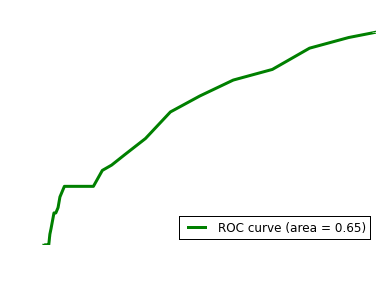

The top 10 most important features:

The daily joy ratio at 15 o'clock
The daily sadness ratio at 14 o'clock
The daily sadness ratio at 15 o'clock
The daily disgust ratio at 13 o'clock
The daily trust ratio at 22 o'clock
The daily anger ratio at 9 o'clock
The daily joy ratio at 13 o'clock
The daily surprise ratio at 22 o'clock
The daily sadness ratio at 21 o'clock
The daily anger ratio at 15 o'clock


In [40]:
BPDUsersData = getUsersData("BPD_fixed_emotion")
regularUsersData = getUsersData("regularUser_en_fixed_emotion")
featuresList = featureExtraction([regularUsersData, BPDUsersData], text_extraction=False)
forest = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)

classifer = plot_ROC(forest, featuresList)
try:
    featureScores = np.argsort(classifer.feature_importances_)[::-1]
except:
    featureScores = np.argsort(np.fabs(classifer.coef_[0]))[::-1]
showImportantFeatures(featureScores, None)


401 Normal and 14 BPD in Training Data
45 Normal and 2 BPD in Test Data
Number of features: 200


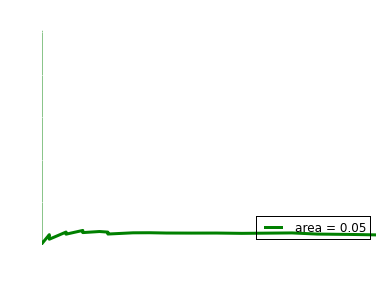

In [41]:

classifer = plot_precision_recall(forest, featuresList)
try:
    featureScores = np.argsort(classifer.feature_importances_)[::-1]
except:
    featureScores = np.argsort(np.fabs(classifer.coef_[0]))[::-1]
#showImportantFeatures(featureScores, None)


In [42]:
BPDUsersData_text = getUsersData("BPD_fixed_emotion",time=False)
regularUsersData_text = getUsersData("regularUser_en_fixed_emotion",time=False)
featuresList, text_model = featureExtraction([regularUsersData_text, BPDUsersData_text], emotion_extraction=False)
X_train, X_test, Y_train, Y_test = trainTestGenerator(featuresList, randomState =90)


740 Normal and 28 BPD in Training Data
83 Normal and 3 BPD in Test Data
Number of features: 4532517


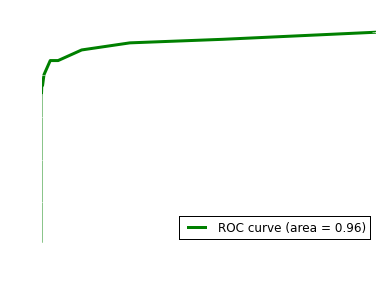

The following are the top 50 most important features:

skills bpdchat
carldunnjr
just bpd
bpdqueen
diagnosis
dialecticallife
bpd just
glass1ncision
mental health
gemmaluescher
asdaserviceteam ordered
mhchat child
bpdchat week
drowninginbpd
89 come
healingfrombpd
bpdchat
know bpd
musicluv47
bpd bipolar
bpd diagnosis
hope ok
life bpdchat
adandelionmind
want run
maybe thought
amp triggers
bpdchat littlepumacub
don bpd
empathise
loveluciusworld
regulating emotions
phone http
success positive
people bpdchat
dbt
fieldingpolly
sat asdaserviceteam
abandonment
bpdme_ write
amp yes
borderline
therapy
realise close
transformental
help bpdchat
night meds
bpd ll
consider maybe
ok just


In [43]:
#classifer = plot_ROC(RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128), featuresList)
classifer = plot_ROC(forest, featuresList)

try:
    featureScores = np.argsort(classifer.feature_importances_)[::-1]
except:
    featureScores = np.argsort(np.fabs(classifer.coef_[0]))#[::-1]
    
showImportantFeatures(featureScores, text_model, n_features=50)

740 Normal and 28 BPD in Training Data
83 Normal and 3 BPD in Test Data
Number of features: 4532517


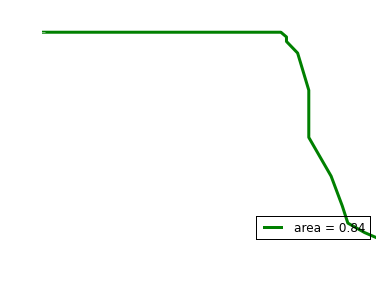

In [44]:

#classifer = plot_precision_recall(RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128), X_train, X_test, Y_train, Y_test)

classifer = plot_precision_recall(forest,featuresList)

try:
    featureScores = np.argsort(classifer.feature_importances_)[::-1]
except:
    featureScores = np.argsort(np.fabs(classifer.coef_[0]))#[::-1]
    
#showImportantFeatures(featureScores, text_model, n_features=50)
    

In [45]:
regularUsersData_text = getUsersData("regularUser_en_fixed_emotion", time=False)
BPDUsersData_text =getUsersData("BPD_581",time=False)
featuresList, text_model = featureExtraction([regularUsersData_text, BPDUsersData_text], emotion_extraction=False)
X_train, X_test, Y_train, Y_test = trainTestGenerator(featuresList, randomState =90)

In [ ]:
featuresList[0][0]

<823x5894967 sparse matrix of type '<class 'numpy.float64'>'
	with 7253697 stored elements in Compressed Sparse Row format>

In [ ]:
forest = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)
classifer = plot_ROC(forest, featuresList)

try:
    featureScores = np.argsort(classifer.feature_importances_)[::-1]
except:
    featureScores = np.argsort(np.fabs(classifer.coef_[0]))#[::-1]
    
showImportantFeatures(featureScores, text_model, n_features=50)

In [ ]:
forest = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)
classifer = plot_precision_recall(forest,featuresList)

try:
    featureScores = np.argsort(classifer.feature_importances_)[::-1]
except:
    featureScores = np.argsort(np.fabs(classifer.coef_[0]))#[::-1]

In [ ]:
# new functions

def getNegativeCount(timeSeries):
    return np.sum(timeSeries["polarity"].values == -1)


def getUsersPolarities(collectionName):
    collection = MongoClient("localhost", 27017)['idea'][collectionName]
    usersPolarties = {}
    for tweet in collection.find():
        userID = tweet["user"]["id"]
        #Processing emotions from Carlos' API
        emotion =  tweet["emotion"]["groups"][0]["name"]
        if len(tweet["emotion"]["groups"]) > 1:
            emotion_2 = tweet["emotion"]["groups"][1]["name"]
            
        ambiguous = True if tweet['emotion']['ambiguous'] == 'yes' else False
       
        if len(tweet["emotion"]["groups"]) > 1:
            emotion_2 = tweet["emotion"]["groups"][1]["name"]    
        else:
            emotion_2 = None
        if tweet["polarity"] == "positive":
            polarity = 1
        elif tweet["polarity"] == "negative":
            polarity = -1
        else:
            polarity = 0
   
            
        date = tweet["created_at"]
        text = tweet['text']

        if userID not in usersPolarties:
            usersPolarties[userID] = {}
        if date not in usersPolarties[userID]:
            usersPolarties[userID][date] = {}
        usersPolarties[userID][date]['text'] = text
        usersPolarties[userID][date]['polarity'] =  polarity
        usersPolarties[userID][date]['emotion'] =  emotion
        usersPolarties[userID][date]['emotion_2'] =  emotion_2
        usersPolarties[userID][date]['ambiguous'] =  ambiguous
    return usersPolarties


def timeSeriesTransform(usersEmotions):
    for userID in usersEmotions:
        usersEmotions[userID] = pd.DataFrame.from_dict(usersEmotions[userID], orient='index').fillna(0)
        usersEmotions[userID]['dt'] = np.zeros(usersEmotions[userID].shape[0],dtype=float)
        usersEmotions[userID].loc[:-1,'dt'] = (usersEmotions[userID].index[1:].values - usersEmotions[userID].index[:-1].values).astype('timedelta64[s]') / np.timedelta64(60, 's')
    return list(usersEmotions.values())



def userVerify(timeSeries, threshold = 0.5, lowerbound = 50):
    http_rows = getHTTPRows(timeSeries)
    average_http_count = np.sum(http_rows) / timeSeries.shape[0]
    duration = np.max(timeSeries.index.values) -  np.min(timeSeries.index.values)
    duration = duration.astype('timedelta64[s]') / np.timedelta64(604800, 's')
    return (average_http_count < threshold) and (timeSeries.shape[0] > lowerbound) and duration > 1


def groupFilter(group):
    new_group = []
    for timeSeries in group:
        if userVerify(timeSeries):
            new_group.append(cleanPost(timeSeries))
    return new_group




def comboTracker(timeSeries, attribute= "polarity"):
    array = timeSeries[attribute]
    starter = array[0]
    combo = 1
    result = []
    for cursor in array[1:]:
        if starter == cursor:
            combo += 1
        else:
            if combo > 1:
                result.append((starter, combo))
            starter = cursor
            combo = 1
    if combo > 1:
         result.append((starter, combo))
    return result

def getHTTPRows(timeSeries):
    count = 0
    patterns = ['http://','https://']
    conditions = timeSeries['text'].str.contains(patterns[0])
    for pattern in patterns[1:]:
        conditions = conditions | timeSeries['text'].str.contains(pattern)

    return conditions.values


def cleanPost(timeSeries):
    left_text = timeSeries['text'].values[:-1]
    right_text = timeSeries['text'].values[1:]
    conditions = np.ones(timeSeries.shape[0],dtype=bool)
    edit_distance = np.vectorize(distance)
    conditions[:-1] =  conditions[:-1] & (edit_distance(left_text, right_text) > 5)
    patterns = ['http://','https://']
    
    for pattern in patterns:
        conditions = conditions & np.logical_not(timeSeries['text'].str.contains(pattern).values)
    timeSeries = timeSeries[conditions]
    timeSeries.loc[:,'dt'] = np.zeros(timeSeries.shape[0],dtype=float)
    timeSeries.loc[:-1,'dt'] = (timeSeries.index[1:].values - timeSeries.index[:-1].values).astype('timedelta64[s]') / np.timedelta64(60, 's')

    return timeSeries


def getFlipsDuration(timeSeries, flips):
    timeSeries = timeSeries[flips]
    timeSeries.loc[:,'dt'] = np.zeros(timeSeries.shape[0],dtype=float)
    timeSeries.loc[:-1,'dt'] = (timeSeries.index[1:].values - timeSeries.index[:-1].values).astype('timedelta64[s]') / np.timedelta64(60, 's')
    return timeSeries['dt'][:-1].values



def getFlips(timeSeries, attribute= 'polarity'):
    flips = np.zeros(timeSeries.shape[0],dtype=bool)
    polarity = timeSeries[attribute].values[:-1]
    right_elements = timeSeries[attribute].values[1:]
    flips[:-1] = (polarity * right_elements) < 0
    return flips

def seriesContains(timeSeries,method ="first"):
    if method == "first":
        match_function = np.vectorize(firstPronuonDetect)
    elif method == "second":
        match_function = np.vectorize(secondPronuonDetect)
    elif method == "third":
            match_function = np.vectorize(thirdPronuonDetect)


    return match_function(timeSeries["text"].str.lower().str.split().values)
    

def firstPronuonDetect(words, matchers=["i","we","i'd","i'm"]):
    for matcher in matchers:
        if matcher in words:
            return True
    return False


def getFirstPronounCount(timeSeries):
    return np.sum(seriesContains(timeSeries))

def comboTracker(timeSeries, attribute= "polarity"):
    array = timeSeries[attribute]
    starter = array[0]
    combo = 1
    result = []
    for cursor in array[1:]:
        if starter == cursor:
            combo += 1
        else:
            if combo > 1:
                result.append((starter, combo))
            starter = cursor
            combo = 1
    if combo > 1:
         result.append((starter, combo))
    return result




def getCombosCount(timeSeries, matcher = -1, lowerbound = 2):
    combos = comboTracker(timeSeries)
    combos_count = sum([hit for element, hit in combos if element == matcher and hit > lowerbound])
    return combos_count
    


def getFlips(timeSeries, attribute= 'polarity'):
    flips = np.zeros(timeSeries.shape[0],dtype=bool)
    polarity = timeSeries[attribute].values[:-1]
    right_elements = timeSeries[attribute].values[1:]
    flips[:-1] = (polarity * right_elements) < 0
    return flips

def getFlipsCount(timeSeries, upperbound=30, lowerbound = 0):
    flips = getFlips(timeSeries)
    durations = getFlipsDuration(timeSeries, flips)
    return np.sum((durations > lowerbound) & (durations < upperbound) )



def getFlipsDuration(timeSeries, flips):
    timeSeries = timeSeries[flips]
    timeSeries.loc[:,'dt'] = np.zeros(timeSeries.shape[0],dtype=float)
    timeSeries.loc[:-1,'dt'] = (timeSeries.index[1:].values - timeSeries.index[:-1].values).astype('timedelta64[s]') / np.timedelta64(60, 's')
    return timeSeries['dt'][:-1].values


def getTextFeature(usersDataList, text_model):
    if text_model == "tfidf":
        model = TfidfVectorizer(stop_words="english",ngram_range = (1,2))
        to_train = True
    else:
        model = text_model
        to_train = False
        
    getText = lambda data : "\n".join(data["text"].values)
    usersTextsList = []
    totalTexts = []
    for usersData in usersDataList:
        usersTexts = []
        for data in usersData:
            text = getText(data)
            totalTexts.append(text)
            usersTexts.append(text)
        usersTextsList.append(usersTexts)
    
    if to_train:
        model.fit(totalTexts)
    
    featuresList = []
    for usersTexts in usersTextsList:
        featuresList.append(model.transform(usersTexts))
        
    return featuresList, model

        

    
def getPolarityFeature(groups):
    features = []
    for group in groups:
        feature = np.zeros((len(group),4),dtype=float)
        for i, timeSeries in enumerate(group):
            tweets_length = timeSeries.shape[0]
            flips_ratio = getFlipsCount(timeSeries) / tweets_length
            combos_ratio = getCombosCount(timeSeries) / tweets_length
            first_pronoun_ratio = getFirstPronounCount(timeSeries) / tweets_length
            negative_ratio = getNegativeCount(timeSeries) / tweets_length
            feature[i][0] = flips_ratio 
            feature[i][1] = combos_ratio
            feature[i][2] = negative_ratio
            feature[i][3] = first_pronoun_ratio
        features.append(feature)
    return features



def getEmotionFeature(groups):
    features = []
    for group in groups:
        feature = np.zeros((len(group),4+8),dtype=float)
        for i, timeSeries in enumerate(group):
            tweets_length = timeSeries.shape[0]
            flips_ratio = getFlipsCount(timeSeries) / tweets_length
            combos_ratio = getCombosCount(timeSeries) / tweets_length
            first_pronoun_ratio = getFirstPronounCount(timeSeries) / tweets_length
            negative_ratio = getNegativeCount(timeSeries) / tweets_length
            feature[i][0] = flips_ratio 
            feature[i][1] = combos_ratio
            feature[i][2] = negative_ratio
            feature[i][3] = first_pronoun_ratio
            #emotions come in
            
            feature[i][4:] = getEmotionRatio(timeSeries)
            
            
            
        features.append(feature)
    return features


def getEmotionRatio(timeSeries):
    emotions = ['surprise', 'fear', 'sadness', 'disgust', 'trust', 'anticipation', 'anger','joy']
    emotion_ratios = []
    conditions = np.logical_not(timeSeries["ambiguous"].values)
    timeSeries = timeSeries[conditions]

    for emotion in emotions:
        total = np.sum((timeSeries["emotion"].values == emotion))
        emotion_ratio = total / timeSeries.shape[0]
        emotion_ratios.append(emotion_ratio)
        
    return emotion_ratios
        





def getJHFeature(groups):
    features = []
    for group in groups:
        feature = np.zeros((len(group),6),dtype=float)
        for i, timeSeries in enumerate(group):
         
            tweets_rate = tweetRate(timeSeries)
            mentio_rate = mentioRate(timeSeries)
            unique_mentions = uniqueMentions(timeSeries)
            frequent_mentions = frequentMentions(timeSeries)
            negative_ratio = getNegativeRatio(timeSeries)
            positive_ratio = getPositiveRatio(timeSeries)
            
            feature[i][0] = tweets_rate 
            feature[i][1] = mentio_rate
            feature[i][2] = unique_mentions
            feature[i][3] = frequent_mentions 
            feature[i][4] = negative_ratio
            feature[i][5] = positive_ratio
          
        features.append(feature)
    return features

def getCombinedFeature(groups):
    features = []
    for group in groups:
        feature = np.zeros((len(group),9+8),dtype=float)
        for i, timeSeries in enumerate(group):
            tweets_length = timeSeries.shape[0]
            tweets_rate = tweetRate(timeSeries)
            mentio_rate = mentioRate(timeSeries)
            unique_mentions = uniqueMentions(timeSeries)
            frequent_mentions = frequentMentions(timeSeries)
            negative_ratio = getNegativeRatio(timeSeries)
            positive_ratio = getPositiveRatio(timeSeries)
            flips_ratio = getFlipsCount(timeSeries) / tweets_length
            combos_ratio = getCombosCount(timeSeries) / tweets_length
            first_pronoun_ratio = getFirstPronounCount(timeSeries) / tweets_length
            
            feature[i][0] = tweets_rate 
            feature[i][1] = mentio_rate
            feature[i][2] = unique_mentions
            feature[i][3] = frequent_mentions 
            feature[i][4] = positive_ratio
            feature[i][5] = negative_ratio
            feature[i][6] = flips_ratio
            feature[i][7] = combos_ratio
            feature[i][8] = first_pronoun_ratio
            feature[i][9:] = getEmotionRatio(timeSeries)
        features.append(feature)
    return features


def featureExtraction(usersDataList, polarity_extraction=True, text_extraction=True, text_model="tfidf"):
    featuresList = []
 

    if polarity_extraction:
        polarity_features = getPolarityFeature(usersDataList)
        
        if not text_extraction:
            featuresList = polarity_features
        
        
    if text_extraction:
        
        text_features, model = getTextFeature(usersDataList, text_model)
        
        
        if polarity_extraction:
            featuresList = featureCombination(polarity_features, text_features)
        else:
            featuresList = text_features
        
    Ylist = []
    for label, usersData in enumerate(usersDataList):
        Y = np.zeros(len(usersData),dtype=int)
        Y[:] = label
        Ylist.append(Y)
        
    if text_extraction:
        return list(zip(featuresList, Ylist)), model 
    else:
        return list(zip(featuresList, Ylist)) 

def emotionExtraction(groups):

 

    featuresList = getEmotionFeature(groups)
        
  
        
    Ylist = []
    for label, usersData in enumerate(groups):
        Y = np.zeros(len(usersData),dtype=int)
        Y[:] = label
        Ylist.append(Y)
        
  
    return list(zip(featuresList, Ylist)) 
    
    
    
def JHfeatureExtraction(groups):

 

    featuresList = getJHFeature(groups)
        
  
        
    Ylist = []
    for label, usersData in enumerate(groups):
        Y = np.zeros(len(usersData),dtype=int)
        Y[:] = label
        Ylist.append(Y)
        
  
    return list(zip(featuresList, Ylist)) 

    
def CombinedfeatureExtraction(groups):

 

    featuresList =getCombinedFeature(groups)
        
  
        
    Ylist = []
    for label, usersData in enumerate(groups):
        Y = np.zeros(len(usersData),dtype=int)
        Y[:] = label
        Ylist.append(Y)
        
  
    return list(zip(featuresList, Ylist)) 

In [ ]:
BPD_polarities = getUsersPolarities("BPD_581_emotion")
BPD_timeSeries = groupFilter(timeSeriesTransform(BPD_polarities))
regular_polarities = getUsersPolarities("regularUser_en_fixed_emotion")
regular_timeSeries = groupFilter(timeSeriesTransform(regular_polarities))
groups = [regular_timeSeries, BPD_timeSeries]

In [ ]:

coach_polarities = getUsersPolarities("coach_tweets_emotion")
coach_timeSeries = groupFilter(timeSeriesTransform(coach_polarities))

In [ ]:
len(coach_timeSeries)

In [ ]:
coach_feature  = getCombinedFeature([coach_timeSeries])[0]


In [ ]:
featuresList = CombinedfeatureExtraction(groups)
X, Y = XYGenerator(featuresList)



In [ ]:
forest = RandomForestClassifier(n_jobs=-1, n_estimators=1024, max_features="sqrt")
forest.fit(X,Y)
print("Combined Prediction Result:")
print(forest.predict(coach_feature))
print("\n") 
X_GB = X[:,[5,6,7,8,9,10,11,12,13,14,15,16]]
coach_feature_GB = coach_feature[:,[5,6,7,8,9,10,11,12,13,14,15,16]]
forest.fit(X_GB,Y)
print("GB_carlos Prediction Result:")
print(forest.predict(coach_feature_GB))
print("\n")

X_JH = X[:,[0,1,2,3,4,5]]
coach_feature_JH = coach_feature[:,[0,1,2,3,4,5]]
forest.fit(X_JH,Y)
print("John Hopkins Prediction Result:")
print(forest.predict(coach_feature_JH))
print("\n")


In [ ]:

featuresList, text_model = featureExtraction(groups)
forest = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)
classifer = plot_precision_recall(forest, featuresList)

In [ ]:
featuresList, text_model = featureExtraction(groups, polarity_extraction=False)
forest = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)
classifer = plot_precision_recall(forest, featuresList)
try:
    featureScores = np.argsort(classifer.feature_importances_)[::-1]
except:
    featureScores = np.argsort(np.fabs(classifer.coef_[0]))#[::-1]
    
showImportantFeatures(featureScores, text_model, n_features=50)


In [ ]:
featuresList = featureExtraction(groups, text_extraction=False)
classifer = plot_precision_recall(forest, featuresList)
classifer.feature_importances_

In [ ]:
classifer.feature_importances_#1 flip 2.combo 3.negative ratio 4.first pronoun ratio

In [ ]:
JH_featuresList = JHfeatureExtraction(groups)
classifer = plot_precision_recall(forest, JH_featuresList)
classifer.feature_importances_

In [ ]:
com_featuresList = CombinedfeatureExtraction(groups)
classifer = plot_precision_recall(forest, com_featuresList)
classifer.feature_importances_

In [ ]:
def plot_multiple_precision_recall(classifier, featuresLists,names,colors=['r','g','b',"y"] , n_fold=20):
    
    

    fig, ax = plt.subplots()
    ax.spines['bottom'].set_color('white')
    ax.spines['top'].set_color('white') 
    ax.spines['right'].set_color('white')
    ax.spines['left'].set_color('white')
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    ax.title.set_color('white')
    ax.yaxis.label.set_color('white')
    ax.xaxis.label.set_color('white')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall Curve')
    
    for g,featuresList in enumerate(featuresLists):

        SCORES = np.array([])
        LABELS = np.array([])

        X, Y = XYGenerator(featuresList)




        sss = StratifiedShuffleSplit(Y, n_fold, random_state=randint(0,65536) )


        for train_index, test_index in sss:

            X_train, X_test = X[train_index], X[test_index]
            Y_train, Y_test = Y[train_index], Y[test_index]

            classifier.fit(X_train, Y_train)
            score = classifier.predict_proba(X_test)[:,1]
            SCORES = np.concatenate((SCORES, score))
            LABELS = np.concatenate((LABELS, Y_test))


        precision, recall, _ = precision_recall_curve(LABELS, SCORES, pos_label=1)
        average_precision = average_precision_score(LABELS, SCORES)






        BPD_train = np.count_nonzero(Y_train)
        BPD_test = np.count_nonzero(Y_test)
        normal_train = Y_train.shape[0] - BPD_train
        normal_test = Y_test.shape[0] - BPD_test

       

        plt.plot(recall, precision, label=names[g] , color=colors[g],linewidth=3)
      
        plt.legend(loc="lower right")
        
    print("{} Normal and {} BPD in Training Data".format(normal_train,BPD_train))
    print("{} Normal and {} BPD in Test Data".format(normal_test,BPD_test))

    plt.show()


In [ ]:
names = ["GB","GB_Carlos","JH","JH+GB_Carlos"]
new_feature_lists = [featureExtraction(groups, text_extraction=False),emotionExtraction(groups), JHfeatureExtraction(groups),CombinedfeatureExtraction(groups)]

In [ ]:
plot_multiple_precision_recall(RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=1024),new_feature_lists,names)

In [ ]:

coach_polarities = getUsersPolarities("coach_tweets_emotion")
coach_timeSeries = groupFilter(timeSeriesTransform(coach_polarities))


In [ ]:
featuresList, text_model = featureExtraction(groups, polarity_extraction=False)
forest = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)
classifer = plot_precision_recall(forest, featuresList)
try:
    featureScores = np.argsort(classifer.feature_importances_)[::-1]
except:
    featureScores = np.argsort(np.fabs(classifer.coef_[0]))#[::-1]
    
showImportantFeatures(featureScores, text_model, n_features=50)



In [ ]:
coach_feature, _ = getTextFeature([coach_timeSeries], text_model)
coach_X = coach_feature[0]
print(classifer.score(coach_X, np.zeros(coach_X.shape[0],dtype=int)))
classifer.predict(coach_X)

In [ ]:
pd.set_option('display.max_colwidth', 10000)

In [ ]:
patient_x = coach_timeSeries[1]
positive_emotions = ["joy","trust"]
negative_emotions = ["sadness","anger","disgust","fear"]
carlos_polarity = np.zeros(patient_x.shape[0], dtype=int)
for i, emotion in enumerate(patient_x["emotion"].values):
    ambiguity = patient_x["ambiguous"][i]
    if not ambiguity:
        if emotion in positive_emotions:
            carlos_polarity[i] = 1
        elif emotion in negative_emotions:
            carlos_polarity[i] = -1
            
            
patient_x.loc[:,"carlos_polarity"] = carlos_polarity
patient_x.loc[:,"conflict"] = (carlos_polarity * patient_x["polarity"].values) == -1
print("{} Conflicts in {} Post".format(patient_x["conflict"].sum(), patient_x.shape[0]))
patient_x[["text","conflict","polarity","carlos_polarity","emotion"]]


In [ ]:
patient_x[patient_x["conflict"].values]

In [ ]:
sum(getEmotionRatio(patient_x))

In [ ]:
getEmotionFeature(groups)

In [33]:
plot_multiple_precision_recall(RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=1024),new_feature_lists,names)

NameError: name 'plot_multiple_precision_recall' is not defined

In [32]:
3 +4 

7